### Playing with the functional API

In [1]:
%matplotlib inline
## Fast.ai utils
import utils; reload(utils)
from utils import *

Using TensorFlow backend.


In [47]:
# Changing the backend in case it makes any different in the results
def set_keras_backend(backend):

    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

set_keras_backend("tensorflow")

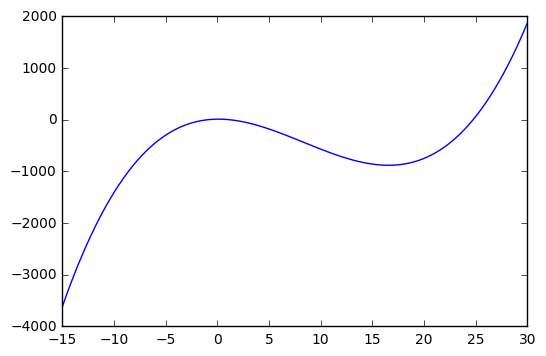

In [134]:
x = np.linspace(-15,30,10000)
def myfun(x):
    return 0.4*x**3 - 10*x**2 + 2*x + 12
#     return 3*x

msk = np.random.rand(len(x)) < 0.8
trainx = x[msk]
valx = x[~msk]
len(valx)
plt.plot(trainx,myfun(trainx))

### Training and validation data

### Creating a model

In [200]:
inputs = Input(shape=(1,), dtype='float', name='x')
x = BatchNormalization()(inputs)
x = Dense(8, activation='relu', W_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dense(8, activation='relu', W_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
y = Dense(1)(x)
# y = Dense(1)(inputs)

model = Model(inputs, y)
model.compile(Adam(0.001), loss='mse')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
x (InputLayer)                   (None, 1)             0                                            
____________________________________________________________________________________________________
batchnormalization_41 (BatchNorm (None, 1)             4           x[0][0]                          
____________________________________________________________________________________________________
dense_69 (Dense)                 (None, 8)             16          batchnormalization_41[0][0]      
____________________________________________________________________________________________________
batchnormalization_42 (BatchNorm (None, 8)             32          dense_69[0][0]                   
___________________________________________________________________________________________

In [201]:
model.fit(trainx, myfun(trainx), batch_size=32, nb_epoch=5, validation_data = (valx, myfun(valx)))

Train on 8023 samples, validate on 1977 samples
Epoch 1/5
8023/8023 [==============================] - 1s - loss: 1051356.1309 - val_loss: 1113298.2939
Epoch 2/5
8023/8023 [==============================] - 0s - loss: 1042607.6123 - val_loss: 1098599.3415

In [202]:
model.optimizer.lr=0.01

In [205]:
model.fit(trainx, myfun(trainx), batch_size=32, nb_epoch=40, validation_data = (valx, myfun(valx)))

Train on 8023 samples, validate on 1977 samples
Epoch 1/40
8023/8023 [==============================] - 0s - loss: 116892.4371 - val_loss: 29365.3789 480/8023 [>.............................] - ETA: 0s - loss: 117493.0928

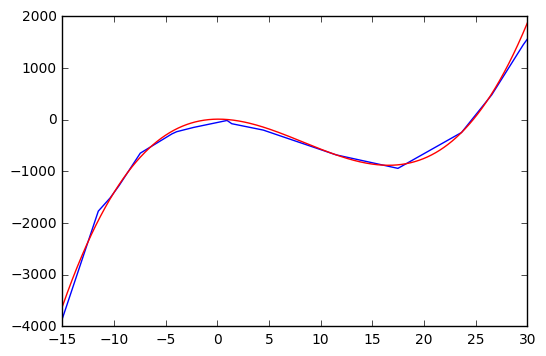

In [206]:
train_predicted = model.predict(trainx, 32)
plt.plot(trainx, train_predicted)
plt.plot(valx, myfun(valx),'r')

In [149]:
train_predicted = model.predict(trainx, 32)

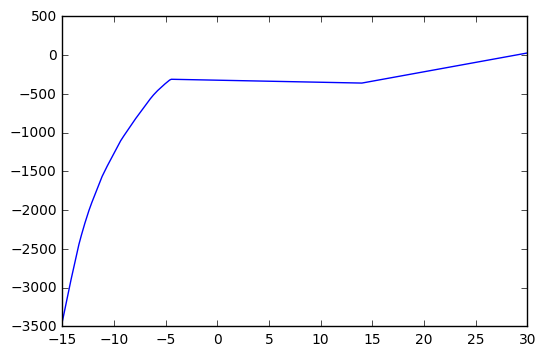

In [150]:
plt.plot(trainx, train_predicted)

# MovieLens classification

## Prep MovieLens data

In [2]:
path = "/srv/data/movielens/ml-latest-small/"
ratings = pd.read_csv(path+'ratings.csv')
pd.read_csv(path+'movies.csv').head()
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()
# gets the unique users and movies
users = ratings.userId.unique()
movies = ratings.movieId.unique()
# index movies
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

In [3]:
# Training and validation split
np.random.seed = 42
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

In [4]:
n_factors = 50

# Creating the model

In [5]:
user = Input(shape=(1,), dtype='int64', name='user')
u = Embedding(n_users, n_factors, W_regularizer=l2(1e-4))(user)
movie = Input(shape=(1,), dtype='int64', name='movie')
m = Embedding(n_movies, n_factors, W_regularizer=l2(1e-4))(movie)

In [6]:
rating = merge([u,m], mode='dot') # the output of this is a 1,1 tensor
rating = Flatten()(rating) # transforms 1,1 tensor into scalar
# rating = Dense(1)(rating)

In [7]:
model = Model([user,movie], rating)

In [8]:
model.compile(Adam(0.001), loss='mse')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
movie (InputLayer)               (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550       user[0][0]                       
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300      movie[0][0]                      
___________________________________________________________________________________________

In [9]:
model.fit([trn.userId,trn.movieId], trn.rating, batch_size=32, nb_epoch=5, validation_data = ([val.userId,val.movieId], val.rating))

Train on 79816 samples, validate on 20188 samples
Epoch 1/5
79816/79816 [==============================] - 42s - loss: 8.1503 - val_loss: 3.4579  160/79816 [..............................] - ETA: 68s - loss: 12.6578 

## Model with bias

In [102]:
user = Input(shape=(1,), dtype='int64', name='user')
u = Embedding(n_users, n_factors, W_regularizer=l2(1e-5), input_length=1)(user)
uwb = Embedding(n_users, 1, input_length=1)(user)
movie = Input(shape=(1,), dtype='int64', name='movie')
m = Embedding(n_movies, n_factors, W_regularizer=l2(1e-5), input_length=1)(movie)
mwb = Embedding(n_movies, 1, input_length=1)(movie)

In [103]:
rating = merge([u,m], mode='dot') # the output of this is a 1,1 tensor
rating = merge([uwb, rating], mode ='sum')
rating = merge([mwb, rating], mode ='sum')
rating = Flatten()(rating) # transforms 1,1 tensor into scalar
model = Model([user,movie], rating)

In [104]:
model.compile(Adam(0.001), loss='mse')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
movie (InputLayer)               (None, 1)             0                                            
____________________________________________________________________________________________________
user (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_13 (Embedding)         (None, 1, 50)         33550       user[0][0]                       
____________________________________________________________________________________________________
embedding_15 (Embedding)         (None, 1, 50)         453300      movie[0][0]                      
___________________________________________________________________________________________

### With or without flatten

In [44]:
user = Input(shape=(1,), dtype='int64', name='user')
u = Embedding(n_users, n_factors, W_regularizer=l2(1e-3), input_length = 1)(user)
uwb = Embedding(n_users, 1, input_length = 1)(user)
uwb = Flatten()(uwb)
movie = Input(shape=(1,), dtype='int64', name='movie')
m = Embedding(n_movies, n_factors, W_regularizer=l2(1e-3), input_length = 1)(movie)
mwb = Embedding(n_movies, 1, input_length = 1)(movie)
mwb = Flatten()(mwb)

In [45]:
rating = merge([u,m], mode='dot') # the output of this is a 1,1 tensor
rating = Flatten()(rating) # transforms 1,1 tensor into scalar

rating = merge([uwb, rating], mode ='sum')
rating = merge([mwb, rating], mode ='sum')
model = Model([user,movie], rating)

In [46]:
model.compile(Adam(0.001), loss='mse')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
movie (InputLayer)               (None, 1)             0                                            
____________________________________________________________________________________________________
user (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_5 (Embedding)          (None, 1, 50)         33550       user[0][0]                       
____________________________________________________________________________________________________
embedding_7 (Embedding)          (None, 1, 50)         453300      movie[0][0]                      
___________________________________________________________________________________________

### Fit

In [47]:
model.fit([trn.userId,trn.movieId], trn.rating, batch_size=1024, nb_epoch=1, validation_data = ([val.userId,val.movieId], val.rating))

Train on 80010 samples, validate on 19994 samples
Epoch 1/1
80010/80010 [==============================] - 1s - loss: 13.4617 - val_loss: 12.8794 4096/80010 [>.............................] - ETA: 3s - loss: 14.0389

In [48]:
model.optimizer.lr=0.01

In [50]:
model.fit([trn.userId,trn.movieId], trn.rating, batch_size=1024, nb_epoch=6, validation_data = ([val.userId,val.movieId], val.rating))

Train on 80010 samples, validate on 19994 samples
Epoch 1/6
80010/80010 [==============================] - 1s - loss: 6.4510 - val_loss: 6.5381 4096/80010 [>.............................] - ETA: 1s - loss: 6.4498

In [51]:
model.optimizer.lr=0.001

In [53]:
model.fit([trn.userId,trn.movieId], trn.rating, batch_size=1024, nb_epoch=100, validation_data = ([val.userId,val.movieId], val.rating))

Train on 80010 samples, validate on 19994 samples
Epoch 1/100
80010/80010 [==============================] - 1s - loss: 3.9963 - val_loss: 4.0334 4096/80010 [>.............................] - ETA: 1s - loss: 3.9883

KeyboardInterrupt: 

In [113]:
model.fit([trn.userId,trn.movieId], trn.rating, batch_size=1024, nb_epoch=10, validation_data = ([val.userId,val.movieId], val.rating))

Train on 80093 samples, validate on 19911 samples
Epoch 1/10
80093/80093 [==============================] - 1s - loss: 0.7652 - val_loss: 1.2994 4096/80093 [>.............................] - ETA: 1s - loss: 0.7647

In [114]:
res = model.predict([np.array([3]), np.array([2])])
np.array([3])

array([3])

In [115]:
res[:10]

array([[ 4.3632]], dtype=float32)

In [116]:
val.rating[:10]

1     3.0
7     2.0
19    3.0
25    3.0
26    3.0
32    3.0
34    3.0
36    3.0
41    3.0
52    2.0
Name: rating, dtype: float64

# Analyze results

In [54]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)
allUsers = ratings.userId.unique()

In [55]:
# best and worst movies
movie_bias_model = Model(movie,mwb)
# best and worst users
user_bias_model = Model(user,uwb)
topMovies

array([  57,   49,   99, ..., 3436, 1804, 1793])

In [56]:
movie_biases = movie_bias_model.predict(topMovies)
user_biases = user_bias_model.predict(allUsers)
rated_user_biases = [(b[0], u) for b,u in zip(user_biases, allUsers)]
rated_user_biases = sorted(rated_user_biases, key=itemgetter(0), reverse = True )
rated_movie_biases = sorted([(b[0], movie_names[movies[u]]) for b,u in zip(movie_biases, topMovies)], reverse = False)
print('Top 5 \n:', rated_movie_biases[:5])
print('Bottom 5 \n:', rated_movie_biases[-5::][::-1])

# for some reason, movie bias stays between 0 and 0.5

('Top 5 \n:', [(-0.50833529, 'Battlefield Earth (2000)'), (-0.32183224, 'Police Academy 6: City Under Siege (1989)'), (-0.095696539, 'Super Mario Bros. (1993)'), (-0.07605546, 'Police Academy 4: Citizens on Patrol (1987)'), (-0.026682673, 'Police Academy 5: Assignment: Miami Beach (1988)')])
('Bottom 5 \n:', [(2.3948777, 'Shawshank Redemption, The (1994)'), (2.2575235, 'Godfather, The (1972)'), (2.2113461, 'Usual Suspects, The (1995)'), (2.1384635, 'Pulp Fiction (1994)'), (2.1318033, "Schindler's List (1993)")])


In [57]:
## embeddings (np.squeeze to reshape)
emb = Model (movie, m)
allmovieembweights = emb.predict(topMovies)
movie_emb = np.squeeze(allmovieembweights)

In [58]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)

In [59]:
movie_pca = pca.fit(movie_emb.T).components_
movie_pca.shape


(3, 2000)

### PCA component 1

In [60]:
pc0 = movie_pca[0]
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(pc0, topMovies)]
print("top movies:\n", sorted(movie_comp, reverse=False)[:5])
print("bottom movies:\n", sorted(movie_comp, reverse=True)[:5])

('top movies:\n', [(-0.1531398722290154, 'Forrest Gump (1994)'), (-0.12957997036147936, 'Ghost (1990)'), (-0.1233679662339604, 'Mission: Impossible (1996)'), (-0.1196376788468734, 'Back to the Future Part III (1990)'), (-0.11579578805555266, 'Speed (1994)')])
('bottom movies:\n', [(0.074965132227147166, 'Silence of the Lambs, The (1991)'), (0.074576147983934596, 'Pulp Fiction (1994)'), (0.054359760683902643, 'All About My Mother (Todo sobre mi madre) (1999)'), (0.053478136356525416, 'Fargo (1996)'), (0.051454522509568182, 'Exotica (1994)')])


In [61]:
### PCA component 2

In [62]:
pc0 = movie_pca[1]
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(pc0, topMovies)]
print("top movies:\n", sorted(movie_comp, reverse=False)[:5])
print("bottom movies:\n", sorted(movie_comp, reverse=True)[:5])

('top movies:\n', [(-0.25461521310775764, 'Forrest Gump (1994)'), (-0.17088023594074755, 'Matrix, The (1999)'), (-0.16020668185747297, 'Star Wars: Episode V - The Empire Strikes Back (1980)'), (-0.15706136407878074, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'), (-0.15421902186226766, 'Star Wars: Episode IV - A New Hope (1977)')])
('bottom movies:\n', [(0.0626600871403028, 'Independence Day (a.k.a. ID4) (1996)'), (0.052949506253215116, 'Into the Wild (2007)'), (0.048691855275297138, 'Naked Gun 33 1/3: The Final Insult (1994)'), (0.048166810717789173, 'Mission: Impossible II (2000)'), (0.048148592788220881, 'Star Wars: Episode I - The Phantom Menace (1999)')])


In [63]:
pc0 = movie_pca[2]
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(pc0, topMovies)]
print("top movies:\n", sorted(movie_comp, reverse=False)[:5])
print("bottom movies:\n", sorted(movie_comp, reverse=True)[:5])

('top movies:\n', [(-0.10372751909919124, 'Twister (1996)'), (-0.094322977521320281, 'Lock, Stock & Two Smoking Barrels (1998)'), (-0.071757624422854036, 'Piano, The (1993)'), (-0.071309003578129984, "You've Got Mail (1998)"), (-0.069713544265102595, 'About Last Night... (1986)')])
('bottom movies:\n', [(0.15240480266944878, 'Star Wars: Episode IV - A New Hope (1977)'), (0.14780073601881083, 'Mission: Impossible (1996)'), (0.13296220074349471, 'Godfather: Part II, The (1974)'), (0.12065812173283788, 'Scrooged (1988)'), (0.11867703188383337, 'Godfather, The (1972)')])


# With a neural net